# Purpose

This script is used to apply the 9 timseries cross-validation models to the the test data (for 2023). 

In [87]:
#high level modules
import os
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
# custom modules
this_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/modeling/SMR_temp_forecast/arNN/"

imp.load_source("universals", os.path.join(this_dir, "universal_functions.py"))
from universals import load_pickle_file, twotemp_labels_features_test, predict_2_values_test, return_test_error_metrics

imp.load_source("vis", os.path.join(this_dir, "vis_functions.py"))
from vis import ts_plot, create_scatter_plot_test

We need to read in the transformed test data, apply the models, and save the resictions.

In [89]:
# import test data
file_path = os.path.expanduser("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/")

test_fn = os.path.join(file_path, "t2023_standardized_v2024-11-25.csv")
with open(test_fn) as f:
    test = pd.read_csv(f, sep=',')

And we need to filter this for our target date - Jul 1 through Sept 11.

In [90]:
# arrange the data by date
test['date'] = pd.to_datetime(test['date'])
test = test.sort_values(by='date')
#test = test.loc[test['date'].between('2023-07-01', '2023-09-11')]

Now we need to apply the models to the test data, but first we need to format the data for the models

In [91]:
test_features, test_labels = twotemp_labels_features_test(test)
test_features.shape, test_labels.shape

((132, 166), (132, 2))

Load the models

In [92]:
# load the models
model_dir = '/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/models/leaky_basic_5_t2023/'

models = [f for f in os.listdir(model_dir) if 'history' not in f]

model_1 = load_pickle_file(models[0], model_dir)
model_2 = load_pickle_file(models[1], model_dir)
model_3 = load_pickle_file(models[2], model_dir)
model_4 = load_pickle_file(models[3], model_dir)
model_5 = load_pickle_file(models[4], model_dir)
model_6 = load_pickle_file(models[5], model_dir)
model_7 = load_pickle_file(models[6], model_dir)
model_8 = load_pickle_file(models[7], model_dir)
model_9 = load_pickle_file(models[8], model_dir)


Now we need to apply the models to the test data and get the resictions, for which we also need the standarization parameters to back calculate.

In [93]:
transform = pd.read_csv(os.path.join("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/", "mean_std_train_val_t2023_v2024-11-25.csv"), sep=',')
transform = transform.rename(columns={"Unnamed: 0": "feature"}).set_index("feature")

t_mean_1m = transform['mean'].get('mean_1m_temp_degC')
t_std_1m = transform['std'].get('mean_1m_temp_degC')

t_mean_05m = transform['mean'].get('mean_0_5m_temp_degC')
t_std_05m = transform['std'].get('mean_0_5m_temp_degC')

test["pred_1m_1"], test["pred_05m_1"] = predict_2_values_test(model_1, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_2"], test["pred_05m_2"] = predict_2_values_test(model_2, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_3"], test["pred_05m_3"] = predict_2_values_test(model_3, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_4"], test["pred_05m_4"] = predict_2_values_test(model_4, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_5"], test["pred_05m_5"] = predict_2_values_test(model_5, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_6"], test["pred_05m_6"] = predict_2_values_test(model_6, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_7"], test["pred_05m_7"] = predict_2_values_test(model_7, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_8"], test["pred_05m_8"] = predict_2_values_test(model_8, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_9"], test["pred_05m_9"] = predict_2_values_test(model_9, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)

And now, let's make the ensemble prediction to assess the model performance.

In [94]:
test["ts_cv_ensemble_pred_1m"] = np.mean(test[['pred_1m_1', 'pred_1m_2', 'pred_1m_3', 'pred_1m_4', 'pred_1m_5', 'pred_1m_6', 'pred_1m_7', 'pred_1m_8']], axis=1)
test["ts_cv_ensemble_pred_05m"] = np.mean(test[['pred_05m_1', 'pred_05m_2', 'pred_05m_3', 'pred_05m_4', 'pred_05m_5', 'pred_05m_6', 'pred_05m_7', 'pred_05m_8']], axis=1)

In order to compare these with the actual values, we need to load the actual values and calculate the performance metrics. To do this, we will back-calculate using the mean and standard deviation.

In [95]:
test['mean_1m_temp_degC'] = test['mean_1m_temp_degC'] * t_std_1m + t_mean_1m
test['mean_0_5m_temp_degC'] = test['mean_0_5m_temp_degC'] * t_std_05m + t_mean_05m

Let's look at the data from 1m first:

In [96]:
return_test_error_metrics(np.sqrt(test["mean_1m_temp_degC"]), np.sqrt(test["ts_cv_ensemble_pred_1m"]))

Test Datset Error Metrics:
Mean Squared Error: 0.23645090998540078
Mean Absolute Error: 0.3969002210633025
Root Mean Squared Error: 0.4862621823516618
Mean Absolute Percentage Error: 0.027933851122840463


(0.23645090998540078,
 0.3969002210633025,
 0.4862621823516618,
 0.027933851122840463)

And then the data from 0-5m:

In [97]:
return_test_error_metrics(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"])

Test Datset Error Metrics:
Mean Squared Error: 0.289331735497704
Mean Absolute Error: 0.42698544447127107
Root Mean Squared Error: 0.5378956548418141
Mean Absolute Percentage Error: 0.038153523021454604


(0.289331735497704,
 0.42698544447127107,
 0.5378956548418141,
 0.038153523021454604)

Let's look at this in context of the data:

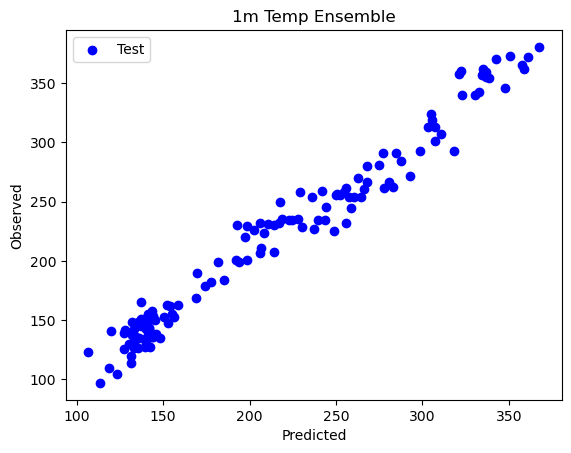

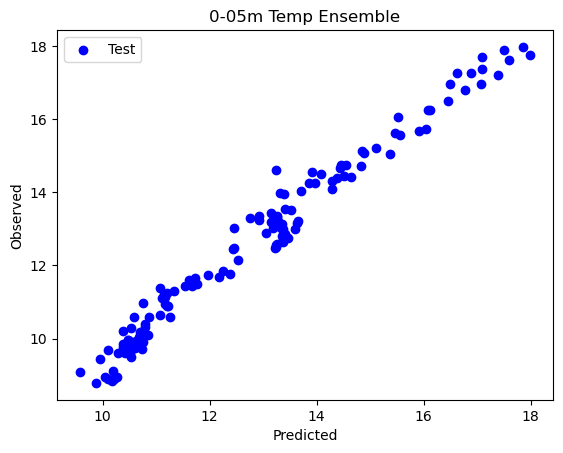

In [98]:
create_scatter_plot_test("1m Temp Ensemble", test["ts_cv_ensemble_pred_1m"], test["mean_1m_temp_degC"])
create_scatter_plot_test("0-05m Temp Ensemble", test["ts_cv_ensemble_pred_05m"], test["mean_0_5m_temp_degC"])

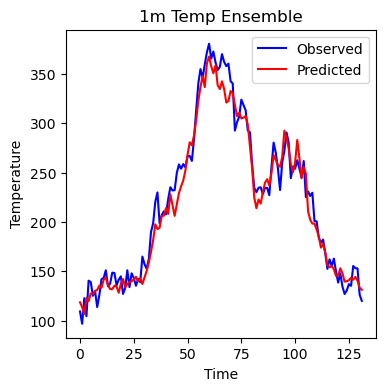

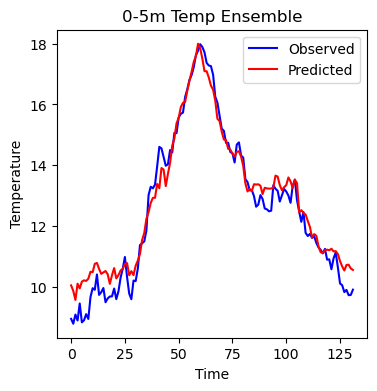

In [99]:
ts_plot(test["mean_1m_temp_degC"], test["ts_cv_ensemble_pred_1m"], "1m Temp Ensemble")
ts_plot(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"], "0-5m Temp Ensemble")


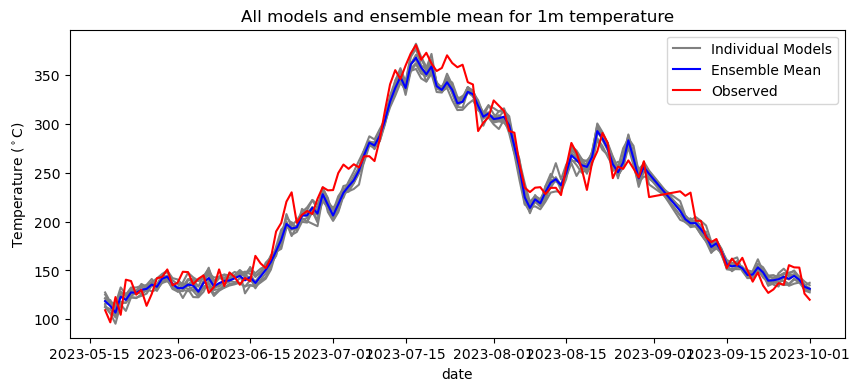

In [100]:
plt.figure(figsize=(10,4))
plt.plot(test['date'], test["pred_1m_1"], label="Individual Models", color='grey')
plt.plot(test['date'], test["pred_1m_2"], color='grey')
plt.plot(test['date'], test["pred_1m_3"], color='grey')
plt.plot(test['date'], test["pred_1m_4"], color='grey')
plt.plot(test['date'], test["pred_1m_5"], color='grey')
plt.plot(test['date'], test["pred_1m_6"], color='grey')
plt.plot(test['date'], test["pred_1m_7"], color='grey')
plt.plot(test['date'], test["pred_1m_8"], color='grey')
plt.plot(test['date'], test["pred_1m_9"], color='grey')
plt.plot(test['date'], test["ts_cv_ensemble_pred_1m"], label="Ensemble Mean", color='blue')
plt.plot(test['date'], test["mean_1m_temp_degC"], label="Observed", color='red')
plt.xlabel("date")
plt.ylabel("Temperature ($^\circ$C)")
plt.legend()
plt.title("All models and ensemble mean for 1m temperature")
plt.show()

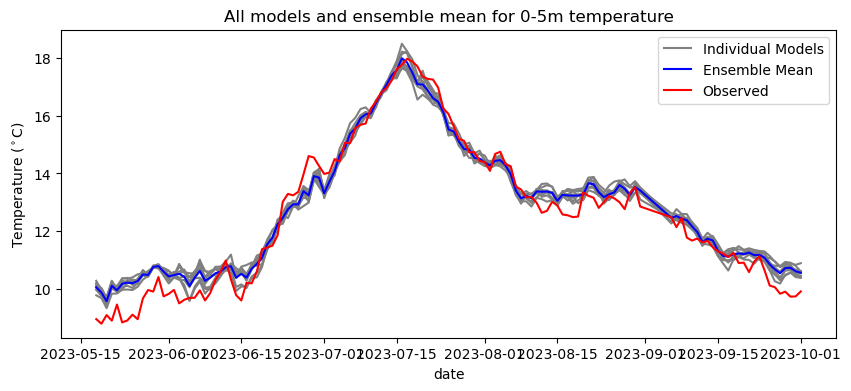

In [101]:
plt.figure(figsize=(10,4))
plt.plot(test['date'], test["pred_05m_1"], label="Individual Models", color='grey')
plt.plot(test['date'], test["pred_05m_2"], color='grey')
plt.plot(test['date'], test["pred_05m_3"], color='grey')
plt.plot(test['date'], test["pred_05m_4"], color='grey')
plt.plot(test['date'], test["pred_05m_5"], color='grey')
plt.plot(test['date'], test["pred_05m_6"], color='grey')
plt.plot(test['date'], test["pred_05m_7"], color='grey')
plt.plot(test['date'], test["pred_05m_8"], color='grey')
plt.plot(test['date'], test["pred_05m_9"], color='grey')
plt.plot(test['date'], test["ts_cv_ensemble_pred_05m"], label="Ensemble Mean", color='blue')
plt.plot(test['date'], test["mean_0_5m_temp_degC"], label="Observed", color='red')
plt.xlabel("date")
plt.ylabel("Temperature ($^\circ$C)")
plt.legend()
plt.title("All models and ensemble mean for 0-5m temperature")
plt.show()



Let's look at the error metrics for the models:

1m results:

Mean Squared Error: 0.24

Mean Absolute Error: 0.40

Root Mean Squared Error: 0.49

Mean Absolute Percentage Error: 2.79


0-5m results:

Mean Squared Error: 0.28

Mean Absolute Error: 0.42

Root Mean Squared Error: 0.53

Mean Absolute Percentage Error: 3.82


Baseline:

1m baseline

Mean Squared Error for 1m baseline : 0.24

Mean Absolute Error for 1m baseline : 0.40

0-5m baseline:

Mean Squared Error for 0-5m baseline : 0.11

Mean Absolute Error for 0-5m baseline : 0.28

Well, pretty good for 1m, not so great for 0-5m. Let's see what happens when we reduce to the time of regulation.

In [102]:
test_regulated = test.loc[test['date'].between('2023-07-01', '2023-09-11')]
return_test_error_metrics(np.sqrt(test_regulated["mean_1m_temp_degC"]), np.sqrt(test_regulated["ts_cv_ensemble_pred_1m"]))
return_test_error_metrics((test_regulated["mean_0_5m_temp_degC"]), (test_regulated["ts_cv_ensemble_pred_05m"]))

Test Datset Error Metrics:
Mean Squared Error: 0.24255106756613565
Mean Absolute Error: 0.40585182697028266
Root Mean Squared Error: 0.4924947386177193
Mean Absolute Percentage Error: 0.02432495730138768
Test Datset Error Metrics:
Mean Squared Error: 0.14001988560011758
Mean Absolute Error: 0.2989835764361365
Root Mean Squared Error: 0.37419231098476297
Mean Absolute Percentage Error: 0.021545307372644807


(0.14001988560011758,
 0.2989835764361365,
 0.37419231098476297,
 0.021545307372644807)

__Test Datset Error Metrics 0-1m:__

Mean Squared Error: 0.24

Mean Absolute Error: 0.41

Root Mean Squared Error: 0.49

Mean Absolute Percentage Error: 2.43


__Test Datset Error Metrics 0-5m:__

Mean Squared Error: 0.14

Mean Absolute Error: 0.30

Root Mean Squared Error: 0.37

Mean Absolute Percentage Error: 2.15

Similar error for 1m, but much better for 0-5m


## Create timeseries residual plot

Calculate residuals

In [103]:
test['res_1m_1'] = np.sqrt(test['pred_1m_1']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_2'] = np.sqrt(test['pred_1m_2']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_3'] = np.sqrt(test['pred_1m_3']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_4'] = np.sqrt(test['pred_1m_4']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_5'] = np.sqrt(test['pred_1m_5']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_6'] = np.sqrt(test['pred_1m_6']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_7'] = np.sqrt(test['pred_1m_7']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_8'] = np.sqrt(test['pred_1m_8']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_9'] = np.sqrt(test['pred_1m_9']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_ensemble'] = np.sqrt(test['ts_cv_ensemble_pred_1m']) - np.sqrt(test['mean_1m_temp_degC'])

test['res_05m_1'] = test['pred_05m_1'] - test['mean_0_5m_temp_degC']
test['res_05m_2'] = test['pred_05m_2'] - test['mean_0_5m_temp_degC']
test['res_05m_3'] = test['pred_05m_3'] - test['mean_0_5m_temp_degC']
test['res_05m_4'] = test['pred_05m_4'] - test['mean_0_5m_temp_degC']
test['res_05m_5'] = test['pred_05m_5'] - test['mean_0_5m_temp_degC']
test['res_05m_6'] = test['pred_05m_6'] - test['mean_0_5m_temp_degC']
test['res_05m_7'] = test['pred_05m_7'] - test['mean_0_5m_temp_degC']
test['res_05m_8'] = test['pred_05m_8'] - test['mean_0_5m_temp_degC']
test['res_05m_9'] = test['pred_05m_9'] - test['mean_0_5m_temp_degC']
test['res_05m_ensemble'] = test['ts_cv_ensemble_pred_05m'] - test['mean_0_5m_temp_degC']


In [104]:
yit = test.filter(['mean_0_5m_temp_degC_m1', 'mean_1m_temp_degC_m1'])
yit = yit.shift(periods=1).rename(columns={'mean_0_5m_temp_degC_m1': 'yit_mean_0_5m_temp_degC', 
                                     'mean_1m_temp_degC_m1': 'yit_mean_1m_temp_degC'})
test = pd.concat([test, yit], axis=1)
test['res_yit_0_5m'] = test['yit_mean_0_5m_temp_degC'] - test['mean_0_5m_temp_degC']
test['res_yit_1m'] = np.sqrt(test['yit_mean_1m_temp_degC']) - np.sqrt(test['mean_1m_temp_degC'])


/Users/steeleb/miniconda3/envs/env_NW/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


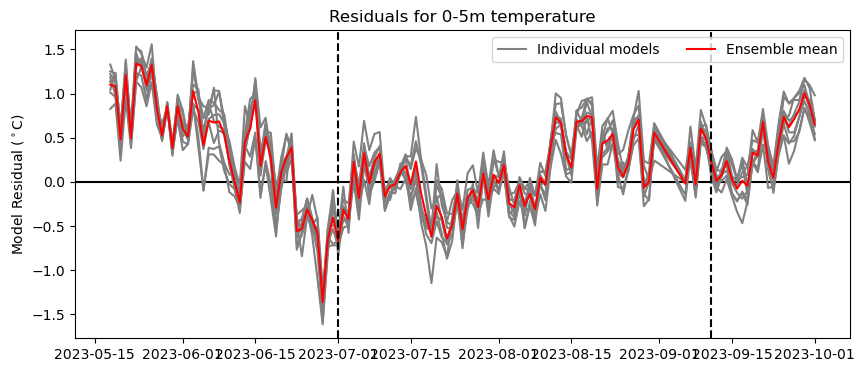

In [108]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_05m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_05m_2"], color='grey')
plt.plot(test['date'], test["res_05m_3"], color='grey')
plt.plot(test['date'], test["res_05m_4"], color='grey')
plt.plot(test['date'], test["res_05m_5"], color='grey')
plt.plot(test['date'], test["res_05m_6"], color='grey')
plt.plot(test['date'], test["res_05m_7"], color='grey')
plt.plot(test['date'], test["res_05m_8"], color='grey')
plt.plot(test['date'], test["res_05m_9"], color='grey')
plt.plot(test['date'], test["res_05m_ensemble"], label="Ensemble mean", color='red')
#plt.plot(test['date'], test["res_yit_0_5m"], label = "yesterday-is-today", color = 'blue')
# add vertical line at regulatory period (July 1 - September 11)
plt.axvline(x=pd.to_datetime('2023-07-01'), color='black', linestyle='--')
plt.axvline(x=pd.to_datetime('2023-09-11'), color='black', linestyle='--')
plt.ylabel("Model Residual ($^\circ$C)")
plt.legend(ncols = 3)
plt.title("Residuals for 0-5m temperature")
plt.show()

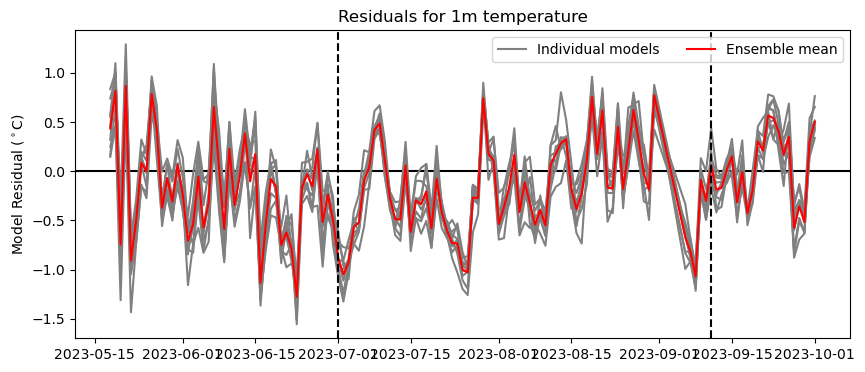

In [109]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_1m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_1m_2"], color='grey')
plt.plot(test['date'], test["res_1m_3"], color='grey')
plt.plot(test['date'], test["res_1m_4"], color='grey')
plt.plot(test['date'], test["res_1m_5"], color='grey')
plt.plot(test['date'], test["res_1m_6"], color='grey')
plt.plot(test['date'], test["res_1m_7"], color='grey')
plt.plot(test['date'], test["res_1m_8"], color='grey')
plt.plot(test['date'], test["res_1m_9"], color='grey')
plt.plot(test['date'], test["res_1m_ensemble"], label="Ensemble mean", color='red')
#plt.plot(test['date'], test["res_yit_1m"], label = "yesterday-is-today", color = 'blue')
# add vertical line at regulatory period (July 1 - September 11)
plt.axvline(x=pd.to_datetime('2023-07-01'), color='black', linestyle='--')
plt.axvline(x=pd.to_datetime('2023-09-11'), color='black', linestyle='--')
plt.ylabel("Model Residual ($^\circ$C)")
plt.legend(ncols = 3)
plt.title("Residuals for 1m temperature")
plt.show()